## Word Embeddings and T-SNE exercise

## Exercise 1: Word Embeddings and t-SNE


A dataset of 10,000 English job ads from job.ch is provided. Your task is to use the word2vec model of the gensim package to map words from the vocabulary to vectors of real numbers. Use t-SNE as a way to visualize these word embeddings. There is a helper file provided in the materials section. Like in any classical NLP task the steps in this analysis are:

Clean the data, remove stop words

Build a corpus

Build and train a Word2Vec model - Play with different parameter settings e.g. window-size etc and save your models

Visualize the resulting model using t-SNE

What do you see in your t-SNE results?

Use-cases:

Extract the 10 most similar words to a given word (e.g. ‘python’)

TSNE is pretty useful when it comes to visualizing similarity between objects. It works by taking a group of high-dimensional (100 dimensions via Word2Vec) vocabulary word feature vectors, then compresses them down to 2-dimensional x,y coordinate pairs. The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words.


Like any classical NLP task the steps in this analysis will be

- Clean data
- Build a corpus
- Train word2vec
- Visualize using t-sne

In [42]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk

from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import os

In [43]:
df = pd.read_pickle("df_clean_newwer_new_last.pkl")
df.shape

(333458, 10)

In [44]:
df.head()

,identifier,speaker_id,file,corpus,configuration,machine,reference.text,hypothesis.text,scoring.wer,recomputed_wer
1,sw2061A-ms98-a-0123,1167,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,yeah because see what happens is they have a g...,yeah because see what happens is they have a g...,0.000000,0.000000
2720,sw2831A-ms98-a-0046,1139,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,i think people are going to follow the stock m...,i think people are going to follow the stock m...,0.000000,0.000000
2721,sw2567B-ms98-a-0068,1159,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,good don't ever drink scotch it's terrible,good don't ever drink scott it's terrible,0.142857,0.142857
2723,sw4276B-ms98-a-0033,1532,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,so they're going to continue,so they're going to continue,0.000000,0.000000
2727,sw3117B-ms98-a-0031,1312,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,and see back when i went to school there when ...,and see back when i went to school there when ...,0.133333,0.133333


In [45]:
#%debug
STOP_WORDS = nltk.corpus.stopwords.words('english')

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = re.sub("\s\s+", " ", sentence)
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data[data['reference.text'] == data['reference.text']]  # removes nan since nan == nan -> False
    
    for col in ['reference.text']:
        data[col] = data[col].apply(clean_sentence)
    
    return data



In [46]:
df = clean_dataframe(df)
df.head(5)

,identifier,speaker_id,file,corpus,configuration,machine,reference.text,hypothesis.text,scoring.wer,recomputed_wer
1,sw2061A-ms98-a-0123,1167,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,yeah see happens good backup policy anybody fix,yeah because see what happens is they have a g...,0.000000,0.000000
2720,sw2831A-ms98-a-0046,1139,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,think people going follow stock market takes,i think people are going to follow the stock m...,0.000000,0.000000
2721,sw2567B-ms98-a-0068,1159,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,good dont ever drink scotch terrible,good don't ever drink scott it's terrible,0.142857,0.142857
2723,sw4276B-ms98-a-0033,1532,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,theyre going continue,so they're going to continue,0.000000,0.000000
2727,sw3117B-ms98-a-0031,1312,amazon__8000_8__switchboard_segmented.json,switchboard_segmented,amazon__8000_8,amazon,see back went school first entered school cost...,and see back when i went to school there when ...,0.133333,0.133333


In [47]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['reference.text', 'hypothesis.text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(df)        
corpus[0:2]

[['yeah', 'see', 'happens', 'good', 'backup', 'policy', 'anybody', 'fix'],
 ['think', 'people', 'going', 'follow', 'stock', 'market', 'takes']]

In [48]:
len(corpus)

666916

In [52]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=200, workers=4)


In [53]:
model2 = word2vec.Word2Vec(corpus, size=100, window=20, min_count=1000, workers=4)


In [50]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\ooles\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


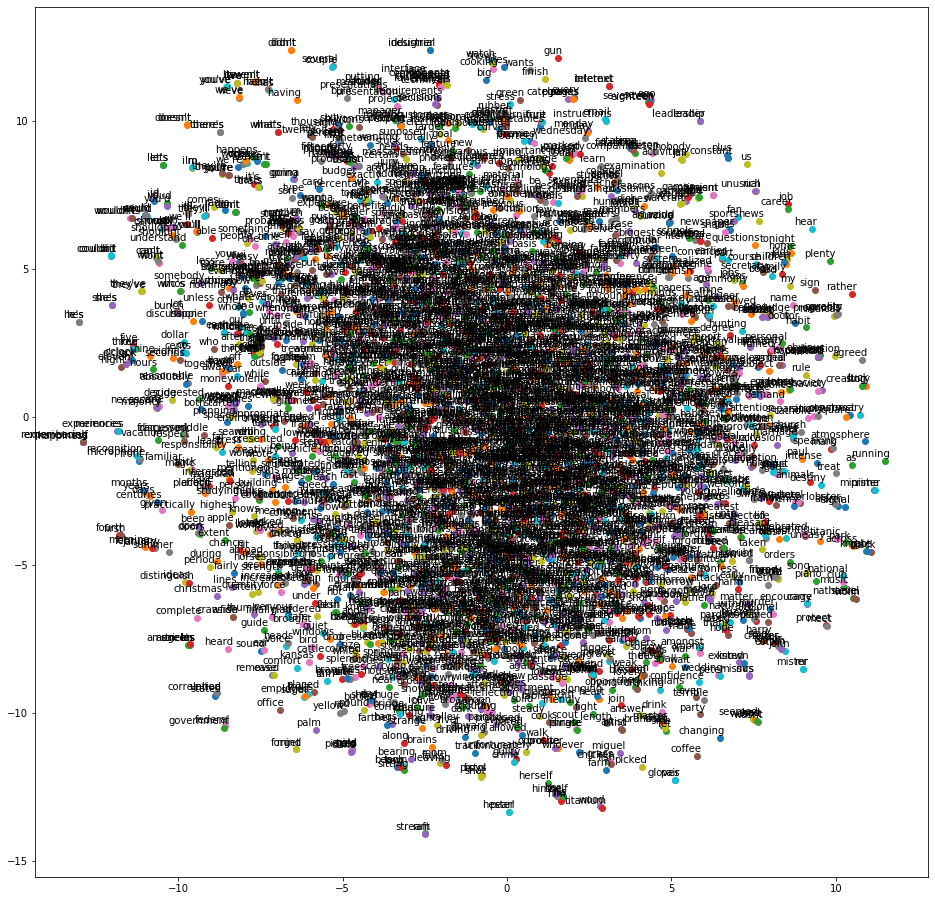

In [51]:
tsne_plot(model)

C:\Users\ooles\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


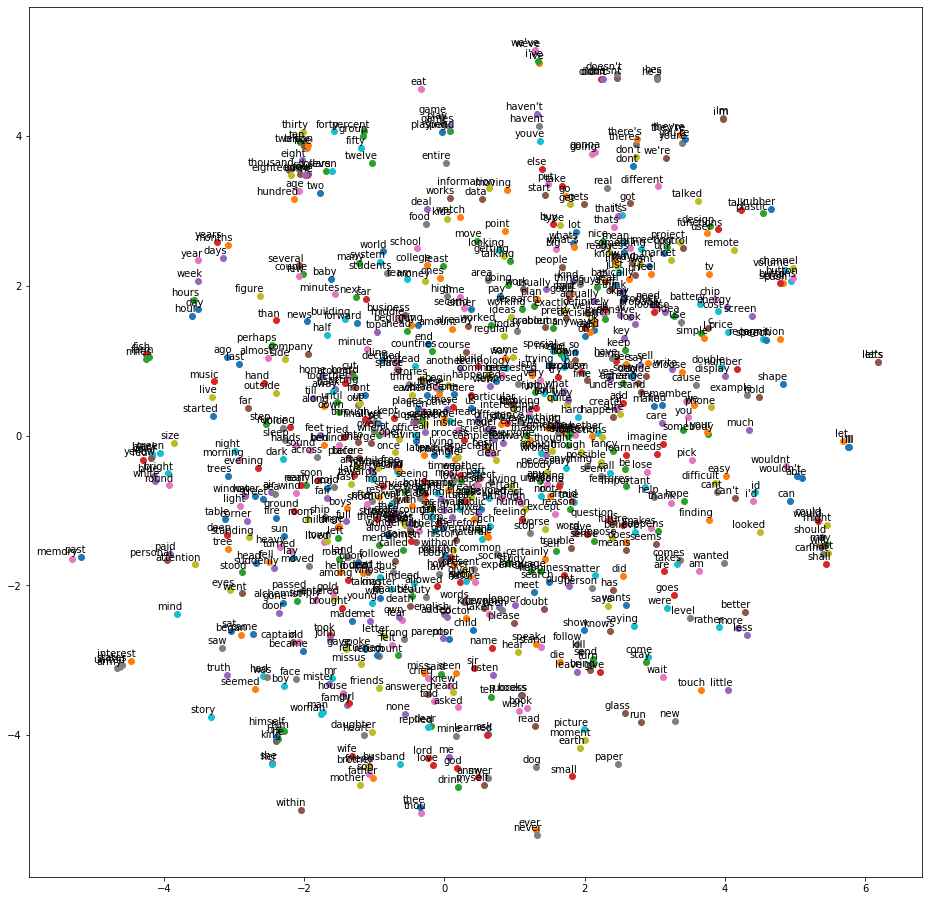

In [54]:
tsne_plot(model2)

In [31]:
model.most_similar("because")

C:\Users\ooles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cuz', 0.5601365566253662),
 ('really', 0.5265100002288818),
 ('so', 0.486925333738327),
 ("'cause", 0.48307105898857117),
 ('but', 0.46365243196487427),
 ('why', 0.41965776681900024),
 ('mean', 0.38905125856399536),
 ('yeah', 0.36137592792510986),
 ('sure', 0.3377486765384674),
 ('think', 0.33699139952659607)]

In [36]:
model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

C:\Users\ooles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('sire', 0.4136110842227936)]

In [30]:
model.doesnt_match(w_r)

C:\Users\ooles\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  """Entry point for launching an IPython kernel.


'because'